## Error bars

This test shows how to extract the purity $p_2=\mathrm{Tr}(\rho^2)$ and the associated error bars. 

In [33]:
using ITensors,ITensorMPS
using RandomMeas
using ProgressMeter

First we load in memory a random quantum state and calculates the purities accross different cuts

In [40]:
N  = 6 #number of qubits
χ = 2^(N÷2) #a large bond-dimension to consider a typical random state
ξ = siteinds("Qubit", N)
ψ = random_mps(ξ; linkdims=χ);

S = [-log2(get_moment(get_spectrum(ψ,NA),2)[1]) for NA in 1:N]
println("Entropies ", S);

Entropies [0.7532465577918485, 1.5199112885068766, 2.089139155900476, 1.841386274066636, 0.9171295242606398, -0.0]


Then we sample randomized measurements 

In [41]:
ITensors.disable_warn_order()
nu = 400
NM = 400
data = zeros(Int8,(nu,NM,N))
u = Vector{Vector{ITensor}}()
@showprogress dt=1 for r in 1:nu
    push!(u,get_rotations(ξ,1)) #Haar rotations in A
    data[r,:,:] = get_RandomMeas(ψ,u[r],NM)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


In [42]:
using Statistics
function JKvariance(estimator,samples)
    ns = length(samples)
    θ = zeros(Float64,ns)
    for i in 1:ns
        θ[i] = estimator(samples[1:end .!= i])
    end
    return var(θ)* (ns - 1)^2 / ns
end

JKvariance (generic function with 1 method)

In [46]:
n = 40 #number of batches
S_est = zeros(Float64,N)
σ= zeros(Float64,N)
@showprogress dt=1 for NA in 1:N
    uA = [ut[1:NA] for ut in u]
    ξA = ξ[1:NA]
    ρs = get_batch_shadows(data[:,:,1:NA],ξA,uA,n);
    estimator(x) = -log2(get_moments(x, ξA, 2)[1])

    S_est[NA] = estimator(ρs)

    σ[NA] = sqrt(JKvariance(estimator,ρs)) 
end   
println("estimated purities ",ps);
println("estimated stat errors ",σ);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:30


estimated purities [0.7602925239765206, 1.5222060683557912, 2.148101860085361, 1.9380765033391354, 0.977908037758922, 0.024721468453242326]
estimated stat errors [0.017790636725036935, 0.03408393988934615, 0.0438389638879717, 0.06705913208730356, 0.08379717772536077, 0.06726855496726926]


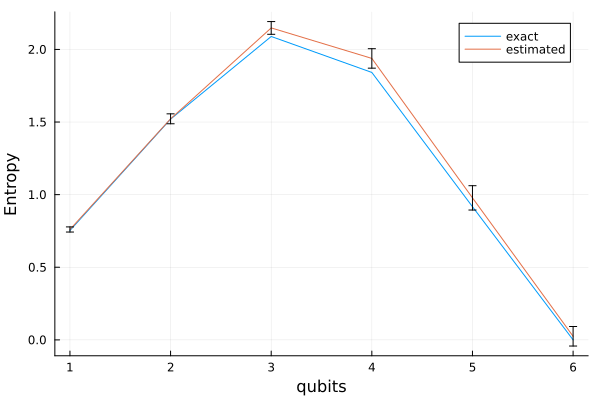

In [47]:
using Plots
plot(1:N,S,label="exact")
plot!(1:N,S_est,yerr = σ,label="estimated")
ylabel!("Entropy")
xlabel!("qubits")